## ДЗ №1 <a name='dz1'></a>


[Набор](https://archive.ics.uci.edu/dataset/2/adult) данных UCI Adult (качать не надо, все есть в репозитории): классификация людей с помощью демографических данных для прогнозирования, зарабатывает ли человек более \$ 50 000 в год.

Описание признаков: 

**Age** – возраст, количественный признак  
**Workclass** – тип работодателя, количественный признак  
**fnlwgt** – итоговый вес обьекта, количественный признак    
**Education** – уровень образования, качественный признак  
**Education_Num** – количество лет обучения, количественный признак  
**Martial_Status** – семейное положение, категориальный признак  
**Occupation** – профессия, категориальный признак  
**Relationship** – тип семейных отношений, категориальный признак    
**Race** – раса, категориальный признак  
**Sex** – пол, качественный признак  
**Capital_Gain** – прирост капитала, количественный признак  
**Capital_Loss** – потери капитала, количественный признак  
**Hours_per_week** – количество часов работы в неделю, количественный признак  
**Country** – страна, категориальный признак  
   
Целевая переменная: **Target** – уровень заработка, категориальный (бинарный) признак 

1. Выполнить разведочный анализ данных, заполнить пропуски, преобразовать категориальные данные в числовые:
    - Кодируем категориальные признаки 'Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country'. Это можно сделать с помощью метода pandas get_dummies.
    
2. В тестовой выборке не оказалось Голландии. Завести необходимый признак из нулей.

3. Обучить LogisticRegression(). Использовать в качестве baseline.
4. Обучить k-NN, SVC, Naive Bayes, DecisionTree, RandomForest
5. Обучить SVC с такими параметрами {'classifier__gamma':[0.001, 0.01, 0.1, 1, 10, 100], 'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}
6. Обучить DecisionTreeClassifier c параметрами tree_params = {'max_depth': range(2,11)}
7. Обучить RandomForestClassifier c параметрами forest_params = {'max_depth': range(10, 21), 'max_features': range(5, 105, 10)}
8. Использовать кроссвалидацию и GridSearchCV.
9. Сравнить все модели с baseline
10. Вывести confusion matrix


## ДЗ №2 <a name='dz2'></a>

1. Разбить датасет digits на обучающую и тестовую выборку, 85% и 15% соответственно.
2. Найти лучший классификатор (и лучшие параметры) для этого набора данных.
3. Вывести матрицу несоответствия

## Imports

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split # разбиение данных на тренировочные и тестовые

from sklearn.compose import ColumnTransformer # преобразование столбцов
from sklearn.preprocessing import OneHotEncoder # кодирование категориальных переменных
from sklearn.preprocessing import LabelEncoder

from sklearn.preprocessing import StandardScaler # нормализация и масштабирование данных

from sklearn.linear_model import LogisticRegression # логистическая регрессия
from sklearn.neighbors import KNeighborsClassifier # k-ближайших новых соседей
from sklearn.svm import SVC # SVM для классификации
from sklearn.naive_bayes import GaussianNB # Naive bayes
from sklearn.tree import DecisionTreeClassifier, export_graphviz # Дерево Решений
from sklearn.ensemble import RandomForestClassifier  # Random Forest


from sklearn.tree import plot_tree # отрисовка дерева

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay

from sklearn.model_selection import cross_val_score # кроссвалидация
from sklearn.model_selection import GridSearchCV # подбор гиперпараметров с кроссвалидацией

import gc

sns.set()
%matplotlib inline

import sys
np.set_printoptions(suppress=True)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)

DISPLAY_MAX_ROWS = 20 #20
pd.set_option('display.max_rows', DISPLAY_MAX_ROWS)
pd.set_option('display.max_column', 100) # None)
plt.style.use('seaborn-whitegrid')


# plt.rcParams["figure.figsize"] = (20, 15)

import warnings
warnings.filterwarnings('ignore')

C:\Users\sharp\AppData\Local\Temp\ipykernel_19348\2656280203.py:43: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [64]:
adult_train = pd.read_csv('./../data/adult_train.csv', sep=';')
adult_test = pd.read_csv('./../data/adult_test.csv', sep=';')

## Разведочный анализ и обработка пропусков

In [66]:
print(adult_train.isnull().sum())
print(adult_test.isnull().sum())

Age                  0
Workclass         1836
fnlwgt               0
Education            0
Education_Num        0
Martial_Status       0
Occupation        1843
Relationship         0
Race                 0
Sex                  0
Capital_Gain         0
Capital_Loss         0
Hours_per_week       0
Country            583
Target               0
dtype: int64
Age                 0
Workclass         963
fnlwgt              0
Education           0
Education_Num       0
Martial_Status      0
Occupation        966
Relationship        0
Race                0
Sex                 0
Capital_Gain        0
Capital_Loss        0
Hours_per_week      0
Country           274
Target              0
dtype: int64


In [67]:
adult_train['Target'] = adult_train['Target'].apply(lambda x: 1 if x == ' >50K' else 0)
adult_test['Target'] = adult_test['Target'].apply(lambda x: 1 if x == ' >50K.' else 0)

In [68]:
categorial_columns = ['Workclass', 'Education', 'Martial_Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country']
categorial_columns_Nans = ['Workclass', 'Occupation', 'Country']

for ct in categorial_columns_Nans:
    # пропуски в категориальных переменных заполним модой
    adult_train[ct].fillna(adult_train[ct].mode()[0], inplace=True)
    adult_test[ct].fillna(adult_test[ct].mode()[0], inplace=True)
    

# остальное заполним или средним значением или медианой. Выберем медиану
# df.fillna(df.median(), inplace=True)

In [70]:
print(adult_train.isnull().sum())
print(adult_test.isnull().sum())

Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
Martial_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
dtype: int64
Age               0
Workclass         0
fnlwgt            0
Education         0
Education_Num     0
Martial_Status    0
Occupation        0
Relationship      0
Race              0
Sex               0
Capital_Gain      0
Capital_Loss      0
Hours_per_week    0
Country           0
Target            0
dtype: int64


In [73]:
adult_train.drop(adult_train[adult_train['Country'] == ' Holand-Netherlands'].index[0], inplace=True)

In [74]:
X_train, y_train = adult_train.iloc[:, :-1], adult_train.iloc[:, -1]
X_test, y_test = adult_test.iloc[:, :-1], adult_test.iloc[:, -1]
X_train = pd.get_dummies(adult_train, columns=categorial_columns)
X_test = pd.get_dummies(adult_test, columns=categorial_columns)

## Build models

In [75]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [80]:
def test(models):
    results = {}
    for i in models:
        #fitting
        models[i].fit(X_train, y_train)

        test_score = []
        test_score.append(models[i].score(X_test, y_test))
        results[i] = test_score

        print(f'{i} model')
        y_pred = models[i].predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = models[i].classes_)
        disp.plot()
        plt.show()
    return pd.DataFrame(results)

In [77]:
logistic_reg = LogisticRegression(random_state=0)
kneighbors_reg = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
svc = GridSearchCV(SVC(), param_grid={'gamma':[0.001, 0.1, 1], 'C': [0.001, 0.1, 1]}, n_jobs=-1)
n_bayes = GaussianNB()
decision_tree = GridSearchCV(DecisionTreeClassifier(), param_grid={'max_depth': range(2,11)})
rnd_forest = GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': range(10, 21), 'max_features': range(5, 105, 10)}, n_jobs=-1)

In [78]:
models = {'Logistic': logistic_reg,
           'KNeighbors': kneighbors_reg,
           'SVC': svc,
           'naive bayes': n_bayes,
           'DecisionTree': decision_tree,
           'RandomForest': rnd_forest}

Logistic model


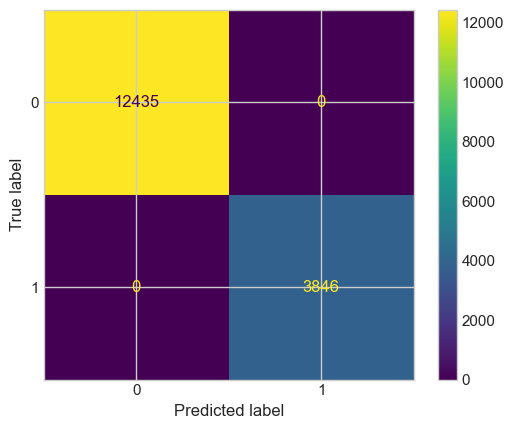

KNeighbors model


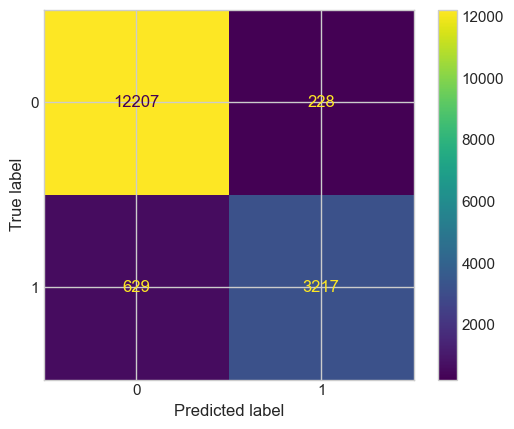

SVC model


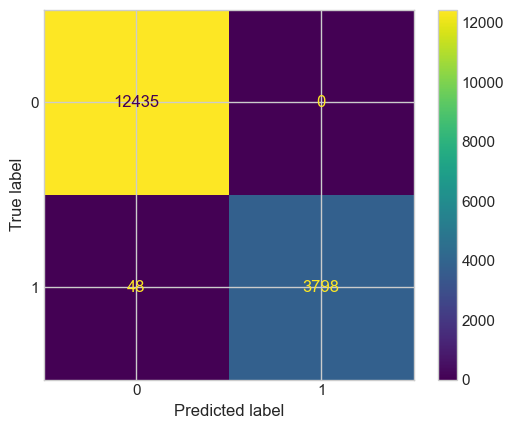

naive bayes model


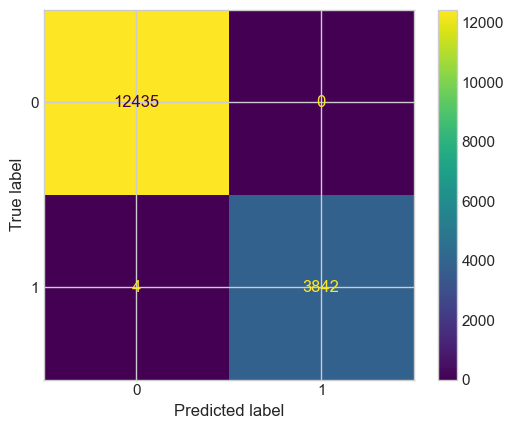

DecisionTree model


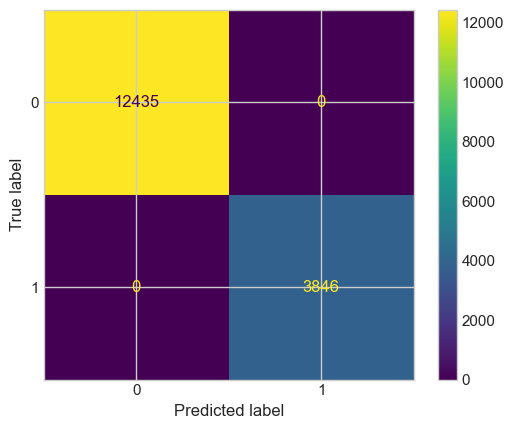

RandomForest model


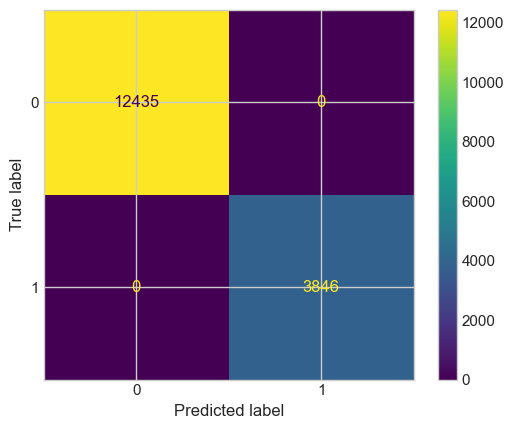

,Logistic,KNeighbors,SVC,naive bayes,DecisionTree,RandomForest
0,1.0,0.947362,0.997052,0.999754,1.0,1.0


In [81]:
test(models)

## ДЗ №2

In [1]:
import numpy as np 
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
digits = load_digits()

X = digits.data
y = digits.target

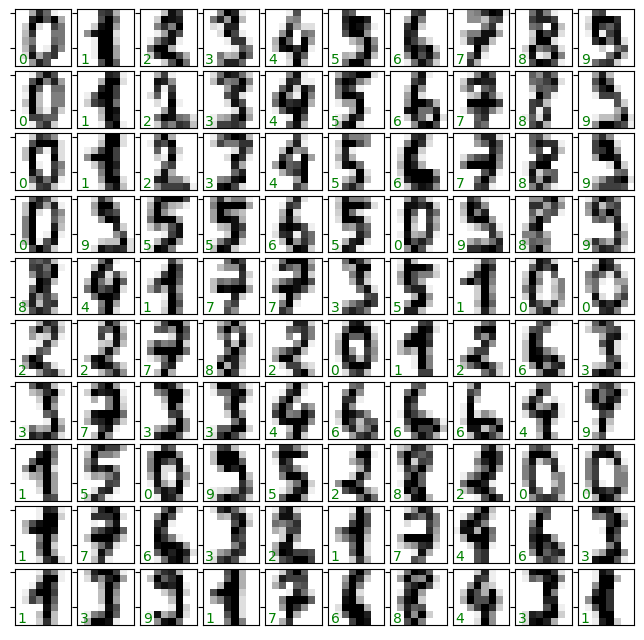

In [2]:
fig, axes = plt.subplots(10,10, figsize=(8,8),
                        subplot_kw={'xticks':[], 'yticklabels':[]},
                        gridspec_kw=dict(hspace=0.1, wspace=0.1))

for i, ax in enumerate(axes.flat):
    ax.imshow(digits.images[i], cmap='binary',
             interpolation='nearest')
    ax.text(0.05, 0.05, str(digits.target[i]),
           transform=ax.transAxes, color='green')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

In [30]:
def find_best(grid_search):
    # включает в себя кроссвалидацию
    grid_search.fit(X_train, y_train)

    best_accuracy = grid_search.best_score_
    best_parameters = grid_search.best_params_

    # confusion matrix
    y_pred = grid_search.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = grid_search.classes_)
    disp.plot()
    plt.show()

    print("Best Accuracy: {:.2f} %".format(best_accuracy*100))
    print("Best Parameters:", best_parameters)


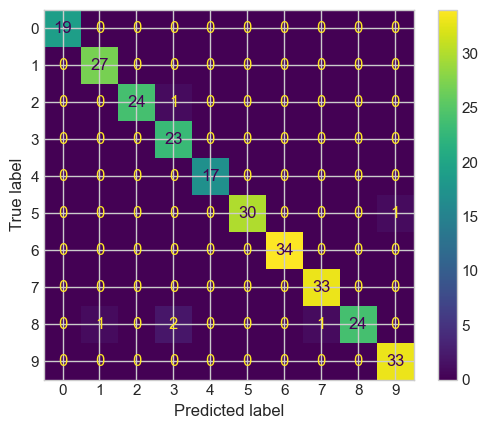

Best Accuracy: 98.76 %
Best Parameters: {'n_neighbors': 5}
KNeighbors


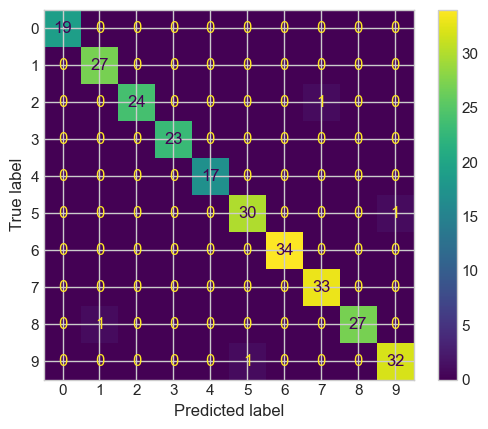

Best Accuracy: 99.15 %
Best Parameters: {'C': 1, 'gamma': 0.001}
SVC


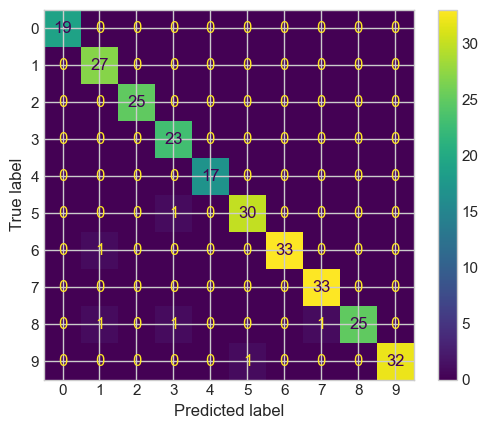

Best Accuracy: 97.64 %
Best Parameters: {'max_depth': 11, 'max_features': 5}
RandomForest


In [32]:
kneighbors_reg = GridSearchCV(KNeighborsClassifier(), param_grid={'n_neighbors': [3, 5, 7, 9]})
svc = GridSearchCV(SVC(), param_grid={'gamma':[0.001, 0.1, 1], 'C': [0.001, 0.1, 1]}, n_jobs=-1)
rnd_forest = GridSearchCV(RandomForestClassifier(), param_grid={'max_depth': range(10, 21), 'max_features': range(5, 105, 10)}, n_jobs=-1)

classifier_models = {
            'KNeighbors': kneighbors_reg,
           'SVC': svc,
           'RandomForest': rnd_forest}

for i in classifier_models:
    find_best(classifier_models[i])
    print(i)